In [1]:
import os
import urllib.request
import copy

import pandas as pd
import numpy as np
import sklearn as sk
import sklearn.metrics
import sklearn.model_selection
import sklearn.svm
import sklearn.cluster
import sklearn.preprocessing
from sklearn import preprocessing
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns

import maui
import maui.utils

Using TensorFlow backend.
/home/phcavelar/miniconda3/envs/maui/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/phcavelar/miniconda3/envs/maui/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/phcavelar/miniconda3/envs/maui/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/phcavela

In [2]:
import functools
import scipy as sp

In [3]:
print(f'Maui version: {maui.__version__}')

Maui version: 0.1.95


# Maui Vignette

This vignette demonstrates use of maui to integrate multi-omics data from colorectal cancer (CRC) tumors and cell lines. Data is from the TCGA and CCLE, respectively.

#### Dependencies

The vignette uses the python packages `matplotlib` and `seaborn` for visualization. These are not required by the maui package and will need to be installed separately.

### Get the data

First, we'll download gene expression, copy number, and mutation data, as well as metadata.

In [4]:
os.makedirs('data/lusc', exist_ok=True)

In [5]:
linearCNA, methylation_hm450, miRNA, RNAseq, clinical_data = map(
    lambda x: pd.read_csv(os.path.join('data', 'lusc', '{}'.format(x)), index_col=0),
    ('linearCNA.csv', 'methylation_hm450.csv', 'miRNA.csv', 'RNAseq.csv', 'clinical_data.csv')
)

clinical_data = clinical_data.rename(columns={"OS_MONTHS":"duration", "OS_STATUS_B": "observed"})
clinical_data = clinical_data.drop(columns=["OS_STATUS"])

list(map(lambda x: x.shape, (linearCNA, methylation_hm450, miRNA, RNAseq, clinical_data)))

[(1354, 501), (15789, 370), (413, 523), (16660, 501), (498, 2)]

In [6]:
linearCNA.head()

,TCGA-18-3406-01,TCGA-18-3407-01,TCGA-18-3408-01,TCGA-18-3409-01,TCGA-18-3410-01,TCGA-18-3411-01,TCGA-18-3412-01,TCGA-18-3414-01,TCGA-18-3415-01,TCGA-18-3416-01,...,TCGA-NK-A5CX-01,TCGA-NK-A5D1-01,TCGA-NK-A7XE-01,TCGA-O2-A52N-01,TCGA-O2-A52Q-01,TCGA-O2-A52S-01,TCGA-O2-A52V-01,TCGA-O2-A52W-01,TCGA-O2-A5IB-01,TCGA-XC-AA0X-01
linearCNA,,,,,,,,,,,,,,,,,,,,,
ACAP3_lcna,0.284,-0.083,-0.775,-0.130,-0.004,-0.458,0.109,-0.132,-0.339,0.049,...,0.043,0.021,0.094,-0.375,-0.438,-0.634,-0.134,0.008,0.973,0.073
CHD5_lcna,0.284,-0.083,-0.775,-0.130,-0.004,-0.458,-0.300,-0.132,-0.339,0.049,...,0.043,0.021,-0.002,-0.375,-0.438,-0.634,-0.134,0.008,0.973,0.073
snoU13|ENSG00000239166.1_lcna,0.284,-0.083,-0.775,-0.130,-0.004,-0.458,-0.300,-0.132,-0.339,0.049,...,0.043,0.021,-0.002,-0.375,-0.438,-0.634,-0.134,0.008,0.973,0.073
IGSF21_lcna,-0.293,-0.083,-0.775,-0.097,-0.004,-0.427,-0.300,-0.132,-0.339,0.049,...,0.043,0.021,-0.002,-0.371,-0.438,-0.634,-0.134,0.008,0.973,0.073
USP48_lcna,-0.293,-0.083,-0.775,-0.097,-0.004,-0.427,-0.300,-0.132,-0.339,0.049,...,0.043,0.021,-0.002,-0.371,-0.438,-0.587,-0.134,0.008,0.973,0.024


In [7]:
methylation_hm450.head()

,TCGA-18-3417-01,TCGA-18-4721-01,TCGA-18-5592-01,TCGA-18-5595-01,TCGA-21-5782-01,TCGA-21-5783-01,TCGA-21-5784-01,TCGA-21-5786-01,TCGA-21-5787-01,TCGA-21-A5DI-01,...,TCGA-NK-A5CX-01,TCGA-NK-A5D1-01,TCGA-NK-A7XE-01,TCGA-O2-A52N-01,TCGA-O2-A52Q-01,TCGA-O2-A52S-01,TCGA-O2-A52V-01,TCGA-O2-A52W-01,TCGA-O2-A5IB-01,TCGA-XC-AA0X-01
methylation_hm450,,,,,,,,,,,,,,,,,,,,,
ITGAD_methy,0.891170,0.889033,0.789863,0.866976,0.883929,0.822402,0.909492,0.857420,0.857641,0.812288,...,0.841334,0.839831,0.676250,0.745151,0.721196,0.883127,0.769006,0.784808,0.888722,0.622420
CHCHD4_methy,0.034287,0.038111,0.039621,0.035316,0.035841,0.042522,0.035286,0.034177,0.035890,0.045942,...,0.044843,0.045451,0.035136,0.045988,0.035134,0.051085,0.050061,0.042674,0.054028,0.107466
C3orf16_methy,0.529693,0.497183,0.634677,0.349162,0.291432,0.478111,0.546544,0.694123,0.835851,0.401454,...,0.452574,0.665563,0.777232,0.885135,0.623257,0.166455,0.559686,0.488755,0.920409,0.647960
C14orf181_methy,0.044581,0.072006,0.064690,0.056125,0.046412,0.049120,0.043906,0.050114,0.055746,0.036869,...,0.033323,0.033596,0.074384,0.047972,0.029782,0.051818,0.049598,0.036010,0.040735,0.050945
MTMR7_methy,0.863003,0.733954,0.915809,0.542608,0.901756,0.657347,0.795159,0.617349,0.604144,0.828396,...,0.872072,0.431689,0.886684,0.798050,0.868448,0.478070,0.847494,0.719551,0.246680,0.823478


In [8]:
miRNA.head()

,TCGA-22-1011-01,TCGA-56-A4ZK-01,TCGA-63-A5MH-01,TCGA-22-5482-01,TCGA-60-2713-01,TCGA-85-7698-01,TCGA-33-6737-11,TCGA-56-8308-01,TCGA-85-A4CL-01,TCGA-43-2576-01,...,TCGA-66-2734-01,TCGA-39-5030-01,TCGA-56-8503-01,TCGA-34-5928-01,TCGA-56-5898-01,TCGA-85-8276-01,TCGA-60-2711-01,TCGA-66-2765-01,TCGA-94-A5I6-01,TCGA-37-3789-01
miRNA,,,,,,,,,,,,,,,,,,,,,
hsa-mir-218-1,18.309202,28.491637,8.696350,38.850697,41.299111,54.286007,126.257312,30.112686,27.212220,23.354013,...,29.180953,23.977893,32.190490,47.042902,26.904761,33.089489,43.318629,22.858078,39.020670,15.676989
hsa-mir-627,0.704200,1.526338,2.536435,9.889268,2.898183,0.690076,0.187048,1.922086,1.700764,2.091404,...,8.337415,0.978690,1.877779,1.557712,4.804422,0.000000,13.328809,1.804585,1.407962,10.660352
hsa-mir-96,9.154601,23.403845,44.931142,40.969826,36.227290,22.772520,3.928005,16.017386,56.368170,23.702580,...,35.434015,35.722168,3.755557,21.184883,46.602890,11.708589,67.754779,29.474890,35.400195,18.185307
hsa-mir-9-1,263.370823,2057.248858,7239.711448,1616.895391,2072.200989,639.930808,38.344813,538.184167,4044.902106,666.460780,...,309.526539,114.017330,925.744854,3639.749819,327.181111,976.903537,922.464652,93.236896,5521.223624,5273.739037
hsa-mir-376b,1.408400,1.271948,0.181174,4.238258,5.796366,2.070229,0.187048,0.640695,0.971865,1.394269,...,3.126531,1.468034,1.877779,2.492339,0.960884,2.036276,0.555367,3.609170,0.804550,12.541591


In [9]:
RNAseq.head()

,TCGA-18-3406-01,TCGA-18-3407-01,TCGA-18-3408-01,TCGA-18-3409-01,TCGA-18-3410-01,TCGA-18-3411-01,TCGA-18-3412-01,TCGA-18-3414-01,TCGA-18-3415-01,TCGA-18-3416-01,...,TCGA-NK-A5CX-01,TCGA-NK-A5D1-01,TCGA-NK-A7XE-01,TCGA-O2-A52N-01,TCGA-O2-A52Q-01,TCGA-O2-A52S-01,TCGA-O2-A52V-01,TCGA-O2-A52W-01,TCGA-O2-A5IB-01,TCGA-XC-AA0X-01
RNAseq,,,,,,,,,,,,,,,,,,,,,
HMGB1P1_mrna,279.9764,198.2540,254.5929,164.3744,200.8033,277.6667,394.3623,205.8704,162.0405,130.9450,...,142.3695,234.1647,133.6915,131.5628,153.5980,176.7177,188.7215,260.3332,160.1624,76.6488
TIMM23_mrna,1510.2362,968.6013,1474.1213,944.6154,1156.0568,1119.5816,861.5023,1030.4597,1931.2139,1426.5530,...,935.5667,777.4533,2257.2693,607.6503,1103.4483,1188.3278,1248.0303,789.3606,460.8626,805.9507
LOC155060_mrna,23.6220,301.6175,49.2362,93.3333,120.9232,33.3903,60.6416,204.1721,35.8382,135.5700,...,226.9226,342.2897,502.5284,789.6175,162.0379,226.8212,147.4945,854.3794,569.2226,311.6273
EFCAB8_mrna,4.7244,0.9515,0.0000,0.0000,7.8777,0.0000,0.7825,1.4768,1.1561,0.5579,...,3.9125,1.7523,21.4918,32.2404,2.4852,2.4834,5.8830,6.4481,2.1299,5.2199
SRP14P1_mrna,10.2362,3.8059,7.7117,7.6923,3.1511,6.0344,1.5649,1.4768,5.7803,3.9053,...,7.8249,6.4252,4.4248,3.8251,14.4144,0.8278,2.5213,5.9108,4.7923,0.0000


In [10]:
clinical_data.head()

,duration,observed
PATIENT_ID,,
TCGA-18-3406-01,12.19,True
TCGA-18-3407-01,4.47,True
TCGA-18-3408-01,75.69,True
TCGA-18-3409-01,123.09,False
TCGA-18-3410-01,4.80,True


In [11]:
#subtypes = pd.read_csv(os.path.join('data', 'subtypes.csv'), index_col=0)
#subtypes.head()

### Scale gene expression data

In [12]:
"""
### Scale gene expression data of TCGA and CCLE separately and together

The gene expression data (FPKM / RPKM) from CCLE and TCGA need to each be scaled separately before being jointly normalized, in order to map them to the same space.
"""
"""
gex_tcga = maui.utils.scale(gex.loc[:,gex.columns.str.contains('TCGA')])
gex_ccle = maui.utils.scale(gex.loc[:,~gex.columns.str.contains('TCGA')])

gex = pd.concat([gex_tcga, gex_ccle], axis=1)
gex = maui.utils.scale(gex)
gex.head()
"""
""

''

In [13]:
miRNA = maui.utils.scale(np.log10(1 + miRNA))

In [14]:
RNAseq = maui.utils.scale(np.log10(1 + RNAseq))

### Reconcile data

In [15]:
clinical_patients = set(clinical_data.index)
RNAseq_patients = set(RNAseq.T.index)
linearCNA_patients = set(linearCNA.T.index)
methylation_hm450_patients = set(methylation_hm450.T.index)
miRNA_patients = set(miRNA.T.index)
all_sets = [clinical_patients, RNAseq_patients, linearCNA_patients, methylation_hm450_patients, miRNA_patients]
all_patients = functools.reduce(lambda x, y: x|y, all_sets, set())
patients_on_all_datasets = functools.reduce(lambda x, y: x&y, all_sets, all_patients)

In [16]:
df_clin = clinical_data.loc[patients_on_all_datasets]
df_mrna = RNAseq.T.loc[patients_on_all_datasets].T
df_lcna = linearCNA.T.loc[patients_on_all_datasets].T
df_methy = methylation_hm450.T.loc[patients_on_all_datasets].T
df_mirna = miRNA.T.loc[patients_on_all_datasets].T

### Get only the 1000 most variable value from each omics layer

In [17]:
def select_top_k_most_variant_rows(df, k, select_least=False):
    argorder = df.T.var().argsort().values
    return df.iloc[argorder[-k:]] if not select_least else df.iloc[argorder[:k]]

In [18]:
df_lcna, df_methy, df_mirna, df_mrna = map(
    lambda df: select_top_k_most_variant_rows(df, k=1000), # filter
    (df_lcna, df_methy, df_mirna, df_mrna)
)

In [19]:
df_mirna

,TCGA-O2-A52S-01,TCGA-90-6837-01,TCGA-92-7341-01,TCGA-34-5929-01,TCGA-63-7020-01,TCGA-96-8169-01,TCGA-56-8307-01,TCGA-92-7340-01,TCGA-63-A5MB-01,TCGA-22-5480-01,...,TCGA-33-4589-01,TCGA-21-5786-01,TCGA-85-8350-01,TCGA-94-8490-01,TCGA-77-A5GA-01,TCGA-52-7809-01,TCGA-56-6545-01,TCGA-98-7454-01,TCGA-56-7582-01,TCGA-22-5474-01
miRNA,,,,,,,,,,,,,,,,,,,,,
hsa-mir-205,0.271649,-3.621373,0.411429,0.761313,0.354148,0.335240,0.734108,0.215592,0.365769,0.604241,...,0.617090,1.012801,0.005258,0.495247,0.459511,0.147626,0.403731,-0.360168,0.480665,0.251976
hsa-mir-210,0.996677,-1.644827,0.411414,-0.620554,0.819140,-1.071092,-0.343766,-0.552674,0.395265,0.551384,...,0.872686,1.124086,0.094101,0.151599,-0.613536,-0.353937,-0.862268,-0.637068,0.236454,0.534580
hsa-mir-148b,-0.270897,0.025837,-1.004256,0.432838,0.408466,-0.275552,0.596253,-0.199112,-0.131278,0.355876,...,0.105761,0.505067,-0.230381,-0.707133,-1.237629,1.199239,-0.791951,0.216985,-0.449131,0.769210
hsa-mir-1976,-0.301159,1.678391,-0.230614,0.216710,0.959643,-0.098663,1.835289,-0.098570,-0.862786,-0.277410,...,-0.057115,0.034975,0.484104,-1.572383,-0.299852,1.267204,0.128570,0.971507,-0.055114,0.958107
hsa-mir-30d,-0.455606,2.287681,-0.648540,-0.357189,0.406598,0.167816,-0.022249,-1.537282,0.007691,-0.923649,...,-1.588884,-1.211834,0.226983,-0.410003,0.122552,0.292383,-0.487267,-0.128895,-0.009241,-0.670829
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
hsa-mir-509-3,1.921316,-0.626590,-0.873754,-0.572936,0.007933,-0.632714,0.220113,-0.974701,1.426174,-0.144157,...,1.730793,-0.334373,-0.780849,-0.845645,0.923735,-0.341182,0.007120,-1.001734,0.917043,0.005227
hsa-mir-509-2,1.644493,-0.443047,-0.989042,-0.215423,0.012274,-0.390259,0.231530,-1.116011,1.314036,0.376160,...,1.366652,-0.282858,-0.733403,-0.971812,1.116204,-0.457122,-0.150849,-0.773559,0.824733,0.255439
hsa-mir-509-1,1.554349,-0.822688,-0.684377,-0.517995,0.088697,-0.826801,0.135207,-0.978653,1.170616,0.376520,...,1.793185,-0.110653,-0.923278,-0.963602,0.859124,-0.515447,-0.276573,-0.948181,0.746746,-0.548971


-----------------------------------

## Fit maui model

With normalized data, we are ready to fit a maui model.

### Setting up tensorflow to only use 1 CPU cure

In [20]:
from keras import backend as K
K.set_session(K.tf.Session(config=K.tf.ConfigProto(intra_op_parallelism_threads=4, inter_op_parallelism_threads=4)))

2022-01-11 14:19:11.679697: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-11 14:19:11.683390: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 1804800000 Hz
2022-01-11 14:19:11.683632: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55fa51dfa820 executing computations on platform Host. Devices:
2022-01-11 14:19:11.683647: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): <undefined>, <undefined>


### Fitting the maui model and infering latent factors in multi-omics data

The `Maui` model implements `sklearn`'s `BaseEstimator` interface. So first we instantiate a model, with the parameters we desire, and then we may fit it using either `fit()` or, to get latent factors out directly, using `fit_transform()`.

We'll instantiate a stacked autoencoder with one hidden layer with 1100 nodes, and a latent layer with 70 nodes, which we'll train over 400 epochs.

In [21]:
maui_model = maui.Maui(n_hidden=[1100], n_latent=70, epochs=400)
%time z = maui_model.fit_transform({'mRNA': df_mrna, 'miRNA': df_mirna, 'Methylation': df_methy, 'CNA': df_lcna})




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



2022-01-11 14:19:12.300052: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1412] (One-time warning): Not using XLA:CPU for cluster because envvar TF_XLA_FLAGS=--tf_xla_cpu_global_jit was not set.  If you want XLA:CPU, either set that envvar, or use experimental_jit_scope to enable XLA:CPU.  To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a proper command-line flag, not via TF_XLA_FLAGS) or set the envvar XLA_FLAGS=--xla_hlo_profile.
OMP: Info #212: KMP_AFFINITY: decoding x2APIC ids.
OMP: Info #210: KMP_AFFINITY: Affinity capable, using global cpuid leaf 11 info
OMP: Info #154: KMP_AFFINITY: Initial OS proc set respected: 0-7
OMP: Info #156: KMP_AFFINITY: 8 available OS procs
OMP: Info #157: KMP_AFFINITY: Uniform topology
OMP: Info #179: KMP_AFFINITY: 1 packages x 4 cores/pkg x 2 threads/core (4 total cores)
OMP: Info #214: KMP_AFFINITY: OS proc to physical thread map:
OMP: Info #171: KMP_AFFINITY: OS proc 0 maps to package 0 core 0 thread 0 
OMP: Info 

CPU times: user 16min 12s, sys: 50.4 s, total: 17min 2s
Wall time: 4min 32s


### Checking model convergence 

<AxesSubplot:>

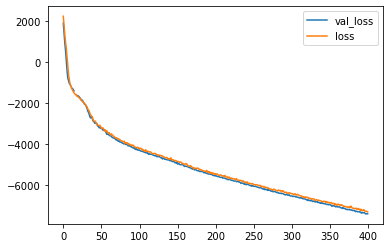

In [22]:
maui_model.hist.plot()

In [23]:
try:
    import winsound         # for sound
    winsound.Beep(440, 250) # frequency, duration
except:
    print("\a"*10)




----------------------------

## Latent factor representation

We now have a set of latent factors, `z`, which describe the variation in the data, across the different omics types.

Let's first see if these latent factors reproduce the known sub-types from the literature. The CRC tumors in the TCGA data have an associated "Consensus Molecular Subtype" (CMS) --- but some samples do not belong to a CMS subtype. Let's first focus on the ones that do.

In [24]:
#y = subtypes.cms_label
#y_cmsonly = y[y!='NOLBL']
#y_cmsonly = y_cmsonly.loc[list(set(y_cmsonly.index) & set(gex.columns))]

In [25]:
#cmap = dict(zip(sorted(y_cmsonly.unique()), sns.color_palette()))
#ycols = [cmap[l] for l in y_cmsonly]

#legend_handles = [mlines.Line2D([], [], color=cmap[label], label=label, marker='o',
#                                markersize=10, linewidth=0) for label in cmap]

#pcs = pd.DataFrame(PCA(2).fit_transform(z), columns=['PC1', 'PC2'], index=z.index).loc[y_cmsonly.index]
#pcs.plot.scatter(x='PC1', y='PC2', c=ycols)
#plt.legend(handles=legend_handles)

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

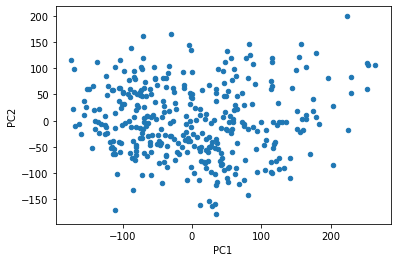

In [26]:
pcs = pd.DataFrame(PCA(2).fit_transform(z), columns=['PC1', 'PC2'], index=z.index)
pcs.plot.scatter(x='PC1', y='PC2')#, c=ycols)

It appears from the PCA that the tumors cluster somewhat by their CMS label. We can use SVMs to see just how predictive the latent factors are of the CMS labels:

In [27]:
#rocs = maui_model.compute_roc(y_cmsonly)

#fig, ax = plt.subplots()
#for k in rocs:
#    rocs[k].plot('FPR','TPR', ax=ax, label=k)
#plt.ylabel("TPR")

In [28]:
#rocs["mean"].plot('FPR','TPR', ax=ax, label=k)

In [29]:
#maui.utils.compute_roc_auc(maui_model.z_, y_cmsonly)

## Clustering

While we think the CMS clusters are generally true, they are based on gene expression data only. We would like to use maui to find new clusters in the data, but with the starting point of the CMS.

To that end, we can use k-means clustering, and pick the K that reaches a result that's the closest to the CMS, where by closest we mean has the most mutual information

In [30]:
# If this doesn't work, try fixing the following line on the code:
#yhat_ = yhats[opt_k_index]
# to
#yhat_ = yhats[optimal_k_]
%time yhat = maui_model.cluster(optimal_k_method="silhouette", kmeans_kwargs={"n_init": 1000}) #ami_y = y_cmsonly, 

CPU times: user 1h 24min 27s, sys: 49min 10s, total: 2h 13min 37s
Wall time: 17min 10s


This gives us the clusters (`yhat`) which are closest to the CMS, but we can also look at the adjusted mutual information (AMI) given by other values of K:

Text(0, 0.5, 'silhouette')

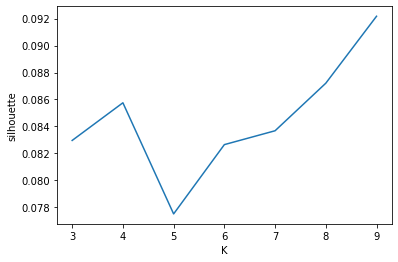

In [31]:
maui_model.kmeans_scores.plot()
plt.ylabel("silhouette")

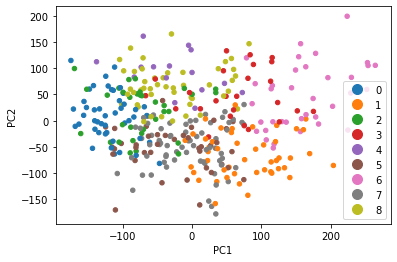

In [32]:
cmap_clusters = dict(zip(sorted(yhat.unique()), sns.color_palette()))
ycols_clusters = [cmap_clusters[l] for l in yhat]

legend_handles = [mlines.Line2D([], [], color=cmap_clusters[label], label=label, marker='o',
                                markersize=10, linewidth=0) for label in cmap_clusters]

pcs = pd.DataFrame(PCA(2).fit_transform(z), columns=['PC1', 'PC2'], index=z.index)#).loc[y_cmsonly.index]
pcs.plot.scatter(x='PC1', y='PC2', c=ycols_clusters)
plt.legend(handles=legend_handles)

### We can see how predictive these clusters are of patient survival

In [33]:
survival = df_clin

Text(0.1, 0.1, 'log-rank p=0.392')

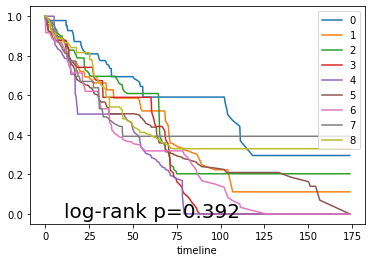

In [34]:
surv_fns = maui.utils.estimate_kaplan_meier(yhat, survival)
surv_fns.plot()
test_stat, p_value = maui.utils.multivariate_logrank_test(yhat, survival)
ax = plt.gca()
ax.text(0.1, .1, f'log-rank p={p_value:.3g}', transform=ax.transAxes, va='top', fontsize=20)

### Get Neural Weight Products

In [35]:
neural_weight_products = maui_model.get_neural_weight_product()

In [36]:
neural_weight_products

,LF1,LF2,LF3,LF4,LF5,LF6,LF7,LF8,LF9,LF10,...,LF61,LF62,LF63,LF64,LF65,LF66,LF67,LF68,LF69,LF70
CNA: ZFP90_lcna,-0.113576,-0.226638,0.205086,0.099095,-0.001420,0.076273,-0.092297,0.084990,0.107530,0.055812,...,-0.102222,0.115761,-0.013732,0.011573,-0.133377,0.174320,-0.065193,-0.009483,-0.017719,-0.028977
CNA: SNORA40|ENSG00000252138.1_lcna,-0.125973,-0.061890,-0.065933,-0.015919,0.091607,-0.217280,-0.123286,0.157283,0.028421,0.077167,...,-0.204393,0.112788,-0.063559,0.157018,-0.036532,0.147443,0.147694,-0.049269,0.057204,-0.000887
CNA: RN7SKP248_lcna,0.074666,0.015160,0.113615,0.136795,0.002874,0.186901,0.095940,-0.026029,-0.051786,-0.036083,...,-0.141287,-0.092755,0.007293,0.041539,0.177276,0.012737,0.017958,0.126455,0.055778,-0.068569
CNA: UACA_lcna,-0.000198,-0.049710,-0.114586,0.074640,-0.040501,-0.081197,0.084355,0.149810,0.093677,-0.080671,...,-0.000569,-0.032927,-0.129363,0.099185,-0.052220,0.000457,0.045680,-0.096288,0.049763,-0.073079
CNA: MIR4264_lcna,-0.129718,-0.171497,-0.100822,-0.035025,-0.105391,0.042653,-0.054580,0.084369,0.023970,0.006595,...,0.041747,0.074314,-0.091800,-0.027755,-0.064043,-0.102317,-0.014006,-0.157813,0.020907,0.051828
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
miRNA: hsa-mir-509-3,-0.012323,0.004170,0.148401,-0.015983,0.095856,-0.063890,-0.206354,0.065099,0.197387,-0.143071,...,-0.068186,-0.064716,-0.020553,-0.121290,0.034505,0.130075,0.024315,0.077377,-0.122276,-0.185970
miRNA: hsa-mir-509-2,0.043870,0.102458,0.012649,0.058539,0.075467,-0.075130,-0.256805,0.027908,0.147686,-0.133712,...,0.038084,-0.043931,-0.052749,-0.029489,0.058614,0.217985,-0.071528,0.155858,-0.124420,-0.250182
miRNA: hsa-mir-509-1,-0.105691,0.054972,0.170820,0.041797,0.083380,-0.016572,-0.162765,0.045279,0.095822,-0.166964,...,0.043188,-0.047639,-0.026271,-0.121263,0.042259,0.184731,-0.067903,0.170616,-0.151013,-0.152825
miRNA: hsa-mir-130a,0.143539,0.423787,-0.032304,0.243698,0.081606,-0.130620,-0.076321,-0.021939,-0.291733,0.075261,...,-0.139376,-0.084049,0.340308,0.143415,0.055984,0.038698,-0.157556,-0.122181,-0.085606,-0.271347


### Selecting latent factors which are most relevant for patient survival

We have inferred many latent factors, most of which might not be predictive of survival on their own. We can filter them down to the ones that are, on their own, using Cox Proportional Hazards (CPH) regressions, while controlling for the covariates in `survival` (age, sex, tumor stage), and only picking the ones which have a statistically significant nonzero coefficient in the CPH regression.

In [37]:
z_clinical = maui_model.select_clinical_factors(survival)
z_clinical.head()

,LF1,LF5,LF21,LF26,LF37,LF53,LF70
TCGA-O2-A52S-01,-0.000000,120.06884,51.707783,-0.000000,-0.000000,63.445686,-0.000000
TCGA-90-6837-01,74.630356,-0.00000,5.508289,-0.000000,20.091127,-0.000000,-0.000000
TCGA-92-7341-01,-0.000000,-0.00000,61.826046,19.022861,-0.000000,-0.000000,-0.000000
TCGA-34-5929-01,-0.000000,-0.00000,4.382526,-0.000000,-0.000000,-0.000000,50.858646
TCGA-63-7020-01,-0.000000,-0.00000,-0.000000,12.983279,22.277349,-0.000000,-0.000000


In [38]:
neural_weight_products.loc[:,z_clinical.columns]

,LF1,LF5,LF21,LF26,LF37,LF53,LF70
CNA: ZFP90_lcna,-0.113576,-0.001420,-0.031974,-0.072618,-0.008777,-0.074025,-0.028977
CNA: SNORA40|ENSG00000252138.1_lcna,-0.125973,0.091607,0.011595,-0.036798,-0.003893,0.060864,-0.000887
CNA: RN7SKP248_lcna,0.074666,0.002874,0.065638,0.056227,0.138077,-0.036654,-0.068569
CNA: UACA_lcna,-0.000198,-0.040501,0.015519,0.196450,0.021080,-0.100127,-0.073079
CNA: MIR4264_lcna,-0.129718,-0.105391,0.095356,-0.026695,0.109315,0.021945,0.051828
...,...,...,...,...,...,...,...
miRNA: hsa-mir-509-3,-0.012323,0.095856,-0.319419,-0.258541,-0.080441,-0.226267,-0.185970
miRNA: hsa-mir-509-2,0.043870,0.075467,-0.249364,-0.299905,-0.159391,-0.225834,-0.250182
miRNA: hsa-mir-509-1,-0.105691,0.083380,-0.202669,-0.232807,-0.201238,-0.177305,-0.152825
miRNA: hsa-mir-130a,0.143539,0.081606,0.078053,-0.074510,0.144960,0.021598,-0.271347


In [39]:
for column in z_clinical.columns:
    weights = neural_weight_products.loc[:,column]
    print(weights[weights.abs() > weights.abs().quantile(0.99)])

mRNA: VENTX_mrna        0.393980
mRNA: FABP5P3_mrna      0.415349
mRNA: CLN8_mrna         0.401141
mRNA: ECSCR_mrna        0.441446
mRNA: PI15_mrna         0.499613
mRNA: CLEC14A_mrna      0.435478
mRNA: C17orf33_mrna     0.466306
mRNA: CD93_mrna         0.484683
mRNA: SLC5A9_mrna       0.405007
mRNA: HYAL1_mrna        0.461127
mRNA: SLC25A13_mrna    -0.485105
mRNA: MAP3K3_mrna       0.419692
mRNA: PARG_mrna        -0.474218
mRNA: RAD52_mrna       -0.400481
mRNA: KLF9_mrna         0.406425
mRNA: PDK4_mrna         0.409991
mRNA: ADAMTS9_mrna      0.429228
mRNA: SERPINE1_mrna     0.415403
mRNA: F2RL3_mrna        0.455592
mRNA: CD300LB_mrna      0.403115
mRNA: PRDM16-DT_mrna    0.411520
mRNA: FHL5_mrna         0.567514
mRNA: CHRDL1_mrna       0.416995
mRNA: RPA4_mrna        -0.403845
mRNA: WNT8B_mrna       -0.440481
mRNA: LYVE1_mrna        0.481617
mRNA: STBD1_mrna        0.409398
mRNA: STAB1_mrna        0.440142
mRNA: CCL14_mrna        0.429475
mRNA: RMI2_mrna        -0.430593
mRNA: FAM1

In [40]:
clinical_maui_model = copy.copy(maui_model)
clinical_maui_model.z_ = z_clinical
z_clinical

,LF1,LF5,LF21,LF26,LF37,LF53,LF70
TCGA-O2-A52S-01,-0.000000,120.068840,51.707783,-0.000000,-0.000000,63.445686,-0.000000
TCGA-90-6837-01,74.630356,-0.000000,5.508289,-0.000000,20.091127,-0.000000,-0.000000
TCGA-92-7341-01,-0.000000,-0.000000,61.826046,19.022861,-0.000000,-0.000000,-0.000000
TCGA-34-5929-01,-0.000000,-0.000000,4.382526,-0.000000,-0.000000,-0.000000,50.858646
TCGA-63-7020-01,-0.000000,-0.000000,-0.000000,12.983279,22.277349,-0.000000,-0.000000
...,...,...,...,...,...,...,...
TCGA-52-7809-01,-0.000000,63.235439,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
TCGA-56-6545-01,45.949970,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
TCGA-98-7454-01,114.886971,3.475856,-0.000000,-0.000000,16.823729,-0.000000,-0.000000
TCGA-56-7582-01,-0.000000,21.728113,11.087173,-0.000000,3.006850,-0.000000,-0.000000


<AxesSubplot:xlabel='PC1', ylabel='PC2'>

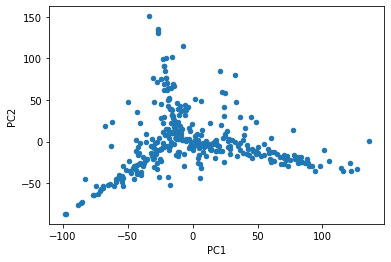

In [41]:
#cmap = dict(zip(sorted(y_cmsonly.unique()), sns.color_palette()))
#ycols = [cmap[l] for l in y_cmsonly]

#legend_handles = [mlines.Line2D([], [], color=cmap[label], label=label, marker='o',
#                                markersize=10, linewidth=0) for label in cmap]

pcs = pd.DataFrame(PCA(2).fit_transform(z_clinical), columns=['PC1', 'PC2'], index=z.index)#.loc[y_cmsonly.index]
pcs.plot.scatter(x='PC1', y='PC2')#, c=ycols)
#plt.legend(handles=legend_handles)

In [42]:
#rocs = clinical_maui_model.compute_roc(y_cmsonly)

#fig, ax = plt.subplots()
#for k in rocs:
#    rocs[k].plot('FPR','TPR', ax=ax, label=k)
#plt.ylabel("TPR")

In [43]:
#maui.utils.compute_roc_auc(clinical_maui_model.z_, y_cmsonly)

In [44]:
%time clinical_yhat = clinical_maui_model.cluster(optimal_k_method="silhouette", kmeans_kwargs={"n_init": 1000}) #ami_y = y_cmsonly

CPU times: user 1min 47s, sys: 2.5 s, total: 1min 50s
Wall time: 22.6 s


Text(0, 0.5, 'silhouette')

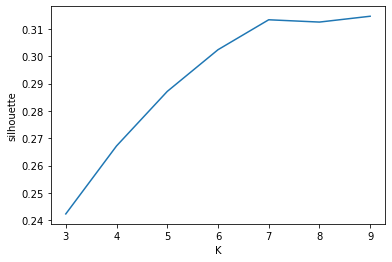

In [45]:
clinical_maui_model.kmeans_scores.plot()
plt.ylabel("silhouette")

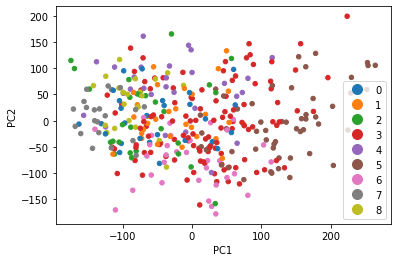

In [46]:
cmap_clusters = dict(zip(sorted(clinical_yhat.unique()), sns.color_palette()))
ycols_clusters = [cmap_clusters[l] for l in clinical_yhat]

legend_handles = [mlines.Line2D([], [], color=cmap_clusters[label], label=label, marker='o',
                                markersize=10, linewidth=0) for label in cmap_clusters]

pcs = pd.DataFrame(PCA(2).fit_transform(z), columns=['PC1', 'PC2'], index=z.index)#.loc[y_cmsonly.index]
pcs.plot.scatter(x='PC1', y='PC2', c=ycols_clusters)
plt.legend(handles=legend_handles)

Text(0.1, 0.1, 'log-rank p=0.00202')

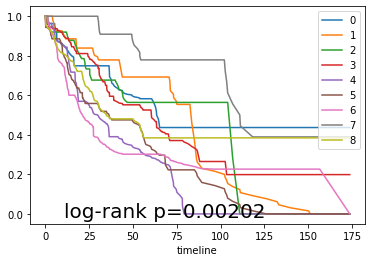

In [47]:
clinical_surv_fns = maui.utils.estimate_kaplan_meier(clinical_yhat, survival)
clinical_surv_fns.plot()
test_stat, p_value = maui.utils.multivariate_logrank_test(clinical_yhat, survival)
ax = plt.gca()
ax.text(0.1, .1, f'log-rank p={p_value:.3g}', transform=ax.transAxes, va='top', fontsize=20)

We might now focus on these latent factors for down-stream analysis, if patient stratification by survival groups is our main interest.

-----------

## Filtering and merging latent factors

We recommend running maui with more latent factors than you think you need. This way you are sure to learn useful ones, and the bad ones can be filtered away.

One way to do this is demonstrated above, using `select_clinical_factors` to trim the list of latent factors to those which are shows to predict patient survival. However, if we're dealing with non-patient data, or we don't have ground truth labels, we may want to drop latent factors based on statistical measures.

Maui provides two ways of doing this:

- Dropping latent factors which are unexplanatory (don't predict the input feature well in a linear model)
- Merging latent factors which are similar

A heatmap shows that there is some co-linearity in the latent factor space:

/home/phcavelar/miniconda3/envs/maui/lib/python3.7/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


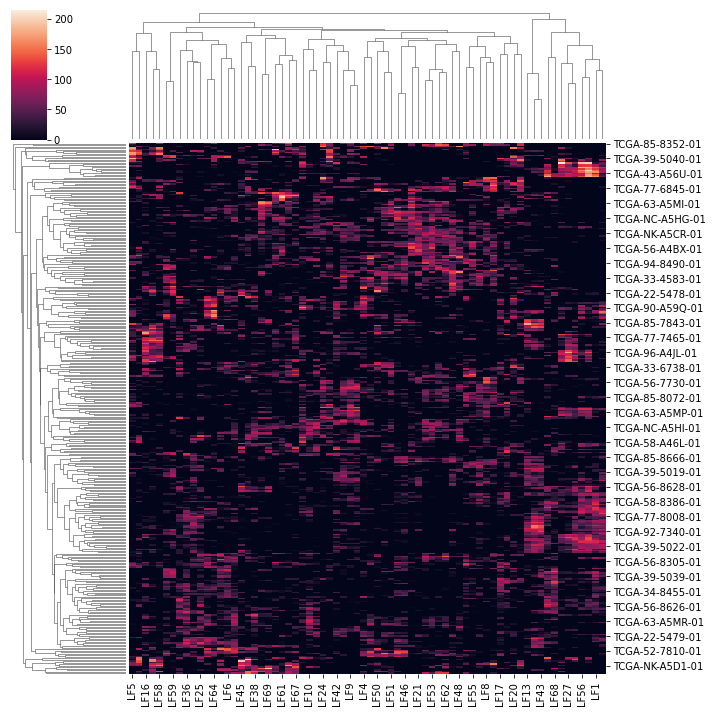

In [48]:
sns.clustermap(maui_model.z_)

Using built-in functionality, we can reduce it by merging latent factors:

In [49]:
merged_maui_model = copy.copy(maui_model)

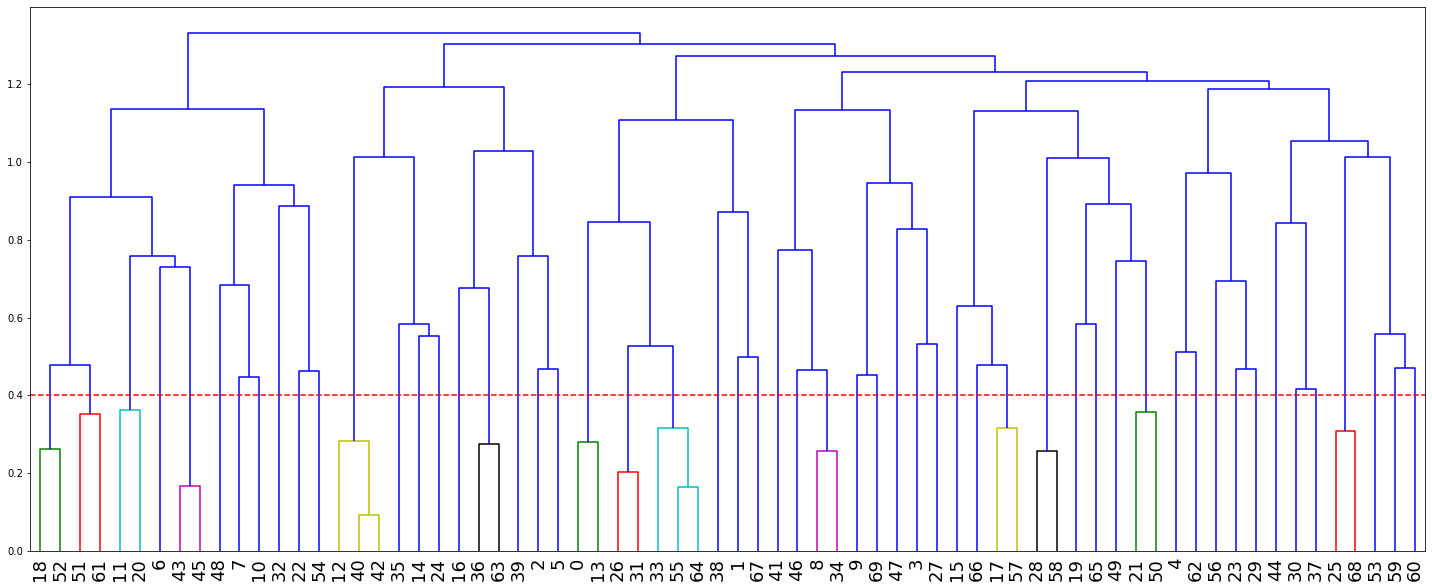

In [50]:
z_merged = merged_maui_model.merge_similar_latent_factors(distance_threshold=.4)

The dendrogram shows ewhich latent factors have been merged, and the threshold level.

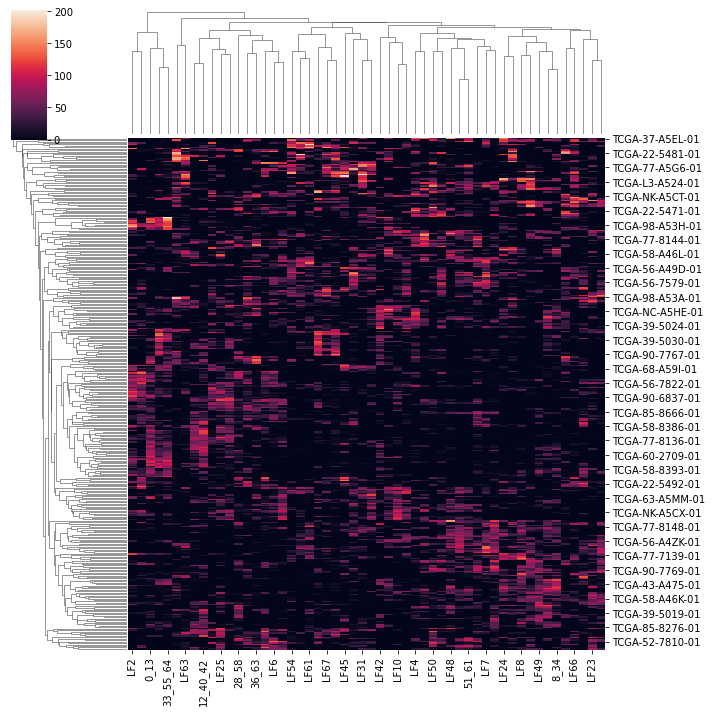

In [51]:
sns.clustermap(z_merged)

In [52]:
z_merged.shape

(356, 54)

Even after merging, some latent factors might poorly explain the variance in the input features. We can drop those also

In [53]:
z_filtered = merged_maui_model.drop_unexplanatory_factors()
z_filtered.shape

(356, 34)

/home/phcavelar/miniconda3/envs/maui/lib/python3.7/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


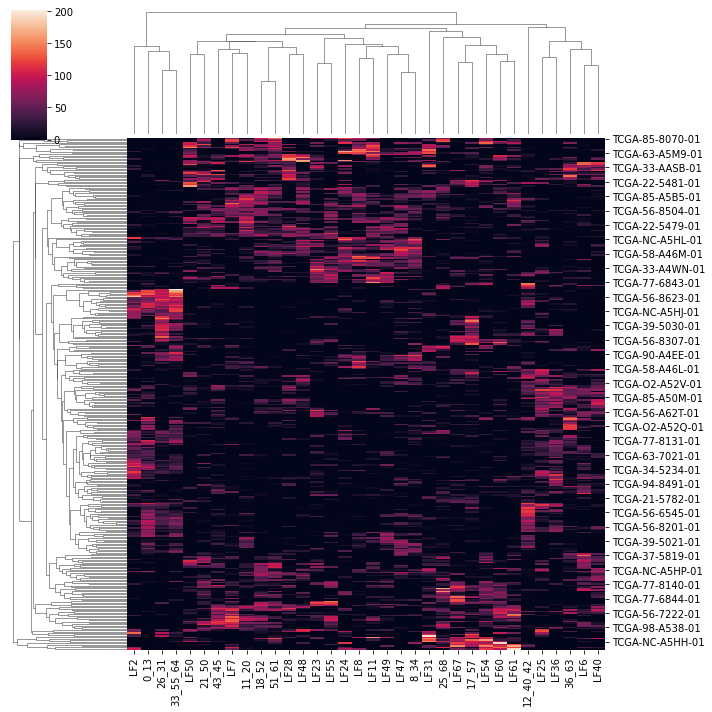

In [54]:
sns.clustermap(z_filtered)

We can also perform the same down-stream analysis using this reduced set of latent factors.

In [55]:
#cmap = dict(zip(sorted(y_cmsonly.unique()), sns.color_palette()))
#ycols = [cmap[l] for l in y_cmsonly]

#legend_handles = [mlines.Line2D([], [], color=cmap[label], label=label, marker='o',
#                                markersize=10, linewidth=0) for label in cmap]

#pcs = pd.DataFrame(PCA(2).fit_transform(z_filtered), columns=['PC1', 'PC2'], index=z.index).loc[y_cmsonly.index]
#pcs.plot.scatter(x='PC1', y='PC2', c=ycols)
#plt.legend(handles=legend_handles)

In [56]:
#rocs = maui_model.compute_roc(y_cmsonly)

#fig, ax = plt.subplots()
#for k in rocs:
#    rocs[k].plot('FPR','TPR', ax=ax, label=k)
#plt.ylabel("TPR")

In [57]:
#maui.utils.compute_roc_auc(maui_model.z_, y_cmsonly)

----------------------------

## The system this was run on.

In [58]:
import IPython
print(IPython.sys_info())

{'commit_hash': '7201b1a',
 'commit_source': 'installation',
 'default_encoding': 'UTF-8',
 'ipython_path': '/home/phcavelar/miniconda3/envs/maui/lib/python3.7/site-packages/IPython',
 'ipython_version': '7.30.1',
 'os_name': 'posix',
 'platform': 'Linux-5.13.0-1022-oem-x86_64-with-debian-bullseye-sid',
 'sys_executable': '/home/phcavelar/miniconda3/envs/maui/bin/python',
 'sys_platform': 'linux',
 'sys_version': '3.7.12 | packaged by conda-forge | (default, Oct 26 2021, '
                '06:08:21) \n'
                '[GCC 9.4.0]'}


In [59]:
!pip freeze

argon2-cffi @ file:///tmp/build/80754af9/argon2-cffi_1613037499734/work
async-generator @ file:///home/ktietz/src/ci/async_generator_1611927993394/work
attrs @ file:///tmp/build/80754af9/attrs_1620827162558/work
backcall @ file:///home/ktietz/src/ci/backcall_1611930011877/work
bleach @ file:///tmp/build/80754af9/bleach_1628110601003/work
brotlipy==0.7.0
certifi==2021.10.8
cffi @ file:///tmp/build/80754af9/cffi_1625814692085/work
chardet @ file:///tmp/build/80754af9/chardet_1607706775000/work
conda==4.10.3
conda-package-handling @ file:///tmp/build/80754af9/conda-package-handling_1618262147379/work
cryptography @ file:///tmp/build/80754af9/cryptography_1616767007030/work
cycler @ file:///home/conda/feedstock_root/build_artifacts/cycler_1635519461629/work
debugpy @ file:///tmp/build/80754af9/debugpy_1629214122703/work
decorator @ file:///tmp/build/80754af9/decorator_1632776554403/work
defusedxml @ file:///tmp/build/80754af9/defusedxml_1615228127516/work
entrypoints==0.3
fonttools @ file: